Mom strat

C:/Users/cooki/OneDrive/Skrivebord/by_ticker_csv

Using 15 tickers: ['ABBV', 'AMGN', 'AZN', 'BIIB', 'BMY']...
3/5  σ=1.9355  Profit=53.52%  Weekly=0.11%
5/5  σ=2.0626  Profit=161.14%  Weekly=0.22%
15/5  σ=2.0266  Profit=71.35%  Weekly=0.13%
30/5  σ=2.0393  Profit=196.23%  Weekly=0.24%


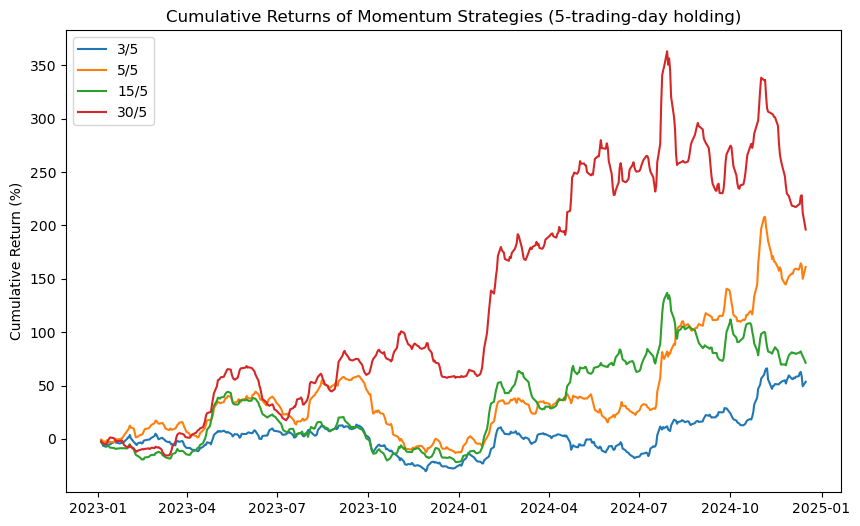

Average 3M T-bill yield over 2023-01-04–2024-12-16: 5.25%


,Obs,Mean (weekly %),Std (weekly %),Sharpe (annual),Ann. Return (%),Ann. Vol (%),RF (annual %)
Strategy,,,,,,,
J=3/5,491,0.106,1.935,0.013,5.437,13.686,5.249
J=5/5,491,0.217,2.063,0.392,11.429,14.585,5.249
J=15/5,491,0.130,2.027,0.097,6.716,14.331,5.249
J=30/5,491,0.242,2.039,0.484,12.844,14.420,5.249


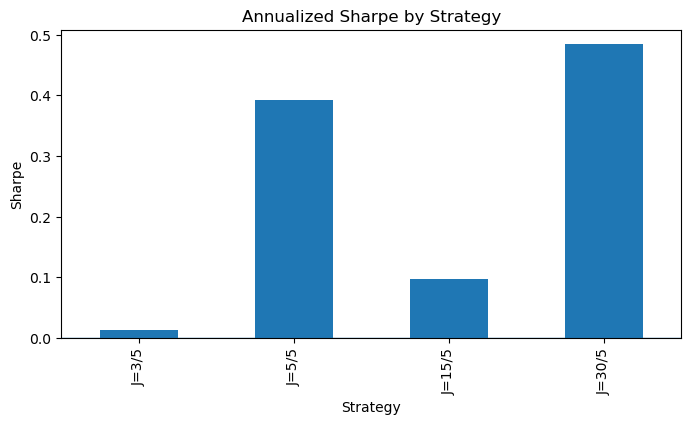

In [19]:
# Pure Momentum Strategy — business-day aware (index-based holding periods)
# ------------------------------------------------------------------------
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
  
# ----------------------------
# Configuration
# ----------------------------
# Path to your unpacked CSV folder
DATA_DIR = r"C:\Users\cooki\OneDrive\Uni\Seminar Econ in financial application\by_ticker_csv"

# Optional filters
TICKERS = ['ABBV', 'AMGN', 'AZN', 'BIIB', 'BMY', 'GILD', 'GSK',
           'JNJ', 'LLY', 'MRK', 'NVO', 'NVS', 'PFE', 'RHHBY', 'SNY']
START = datetime.datetime(2015, 1, 2)
END   = datetime.datetime(2024, 12, 31)
K = 5  # Holding period in BUSINESS days (weekly rebalance ≈ 5 trading days)

# ----------------------------
# Data loading utilities
# ----------------------------
def list_available_tickers():
    """List CSV tickers in the data folder."""
    if not os.path.isdir(DATA_DIR):
        raise FileNotFoundError(f"Data directory not found: {DATA_DIR}")
    tickers = []
    for fn in os.listdir(DATA_DIR):
        if fn.lower().endswith(".csv"):
            tickers.append(os.path.splitext(fn)[0])
    return sorted(tickers)

def load_ticker_data(ticker, start=None, end=None):
    """Load one ticker’s CSV into a DataFrame."""
    path = os.path.join(DATA_DIR, f"{ticker}.csv")
    if not os.path.isfile(path):
        raise FileNotFoundError(f"File not found: {path}")
    df = pd.read_csv(path, parse_dates=["Date"])
    df = df.sort_values("Date")
    if start:
        df = df[df["Date"] >= pd.Timestamp(start)]
    if end:
        df = df[df["Date"] <= pd.Timestamp(end)]
    df["Adj Close"] = df["Close"]
    df["Ticker"] = ticker
    return df

def get_data(tickers, start=None, end=None):
    """Concatenate data for multiple tickers."""
    dfs = [load_ticker_data(t, start, end) for t in tickers]
    all_data = pd.concat(dfs)
    return all_data

# ----------------------------
# Feature preparation
# ----------------------------
def prep_data(tickers, start=None, end=None, K=5):
    all_data = get_data(tickers, start, end)

    daily_close_px = (
        all_data.pivot(index="Date", columns="Ticker", values="Adj Close")
        .sort_index()
    )
    daily_pct_change = daily_close_px.pct_change()

    dly_vars = all_data[["Date", "Ticker", "Adj Close", "Volume"]].rename(columns={"Adj Close": "Price"})
    dly_vars["t-1"] = 0.0
    dly_vars["target"] = 0.0

    # Market returns (unused but kept for completeness)
    mkt_ret = daily_pct_change.mean(axis=1).shift(1)
    def cumret(ser, win): return (ser + 1).rolling(win).apply(np.prod, raw=True) - 1

    # Per-ticker stats
    for coin in tickers:
        sel = dly_vars["Ticker"] == coin
        prices = dly_vars.loc[sel, "Price"]
        dly_vars.loc[sel, "t-1"] = prices.pct_change().shift(1)
        for J in (3, 5, 15, 30):
            dly_vars.loc[sel, f"J_{J}"] = (1 + dly_vars.loc[sel, "t-1"]).rolling(J).apply(np.prod, raw=True) - 1
            dly_vars.loc[sel, f"J_std_{J}"] = (1 + dly_vars.loc[sel, "t-1"]).rolling(J).std()
        # IMPORTANT: shift(-K) uses BUSINESS days because the index is trading dates per ticker
        dly_vars.loc[sel, "target"] = prices.shift(-K) / prices - 1

    dly_vars = dly_vars.dropna().reset_index(drop=True)
    dly_data = dly_vars.set_index("Date")
    dly_target = dly_vars["target"].values
    return dly_vars, dly_data, daily_pct_change, daily_close_px, dly_target

# ----------------------------
# Train/test split
# ----------------------------
def train_test_split(dly_data, daily_close_px, test_ratio=0.2):
    all_dates = sorted(set(dly_data.index).intersection(set(daily_close_px.index)))
    cutoff = int(len(all_dates) * (1 - test_ratio))
    dates_train = pd.Index(all_dates[:cutoff])
    dates_test  = pd.Index(all_dates[cutoff:])

    X_train_df = dly_data.loc[dates_train]
    X_test_df  = dly_data.loc[dates_test]

    data_train = X_train_df.copy()
    data_test  = X_test_df.copy()

    def split_xy(df):
        X = df.reset_index(drop=False)
        y = X["target"].copy()
        X = X.drop(columns=["target","Price","Ticker","Date"], errors="ignore")
        return X, y

    X_train, y_train = split_xy(X_train_df)
    X_test, y_test = split_xy(X_test_df)

    def _reset_with_date(df):
        out = df.reset_index()
        if "Date" not in out.columns and "index" in out.columns:
            out = out.rename(columns={"index": "Date"})
        return out

    return X_train, y_train, X_test, y_test, _reset_with_date(data_train), _reset_with_date(data_test)

# ----------------------------
# Momentum strategy functions
# ----------------------------
def Momentum(pred_r, date, K, daily_close_px):
    """
    pred_r: pivoted DataFrame (index=trading dates, columns=tickers) with the signal (e.g., J_*)
    date:   current trading date (must be in pred_r.index)
    K:      holding period in BUSINESS days (index steps)
    """
    # Ensure 'date' exists in the signal index
    try:
        cur_idx = pred_r.index.get_loc(date)
    except KeyError:
        return np.nan, np.nan, np.nan

    next_idx = cur_idx + K
    if next_idx >= len(pred_r.index):
        return np.nan, np.nan, np.nan

    next_date = pred_r.index[next_idx]

    # Also ensure both dates are present in the price panel
    if (date not in daily_close_px.index) or (next_date not in daily_close_px.index):
        return np.nan, np.nan, np.nan

    # Cross-section on current date
    ret = pred_r.loc[date].reset_index()
    ret.columns = ["Ticker", "Signal"]
    # 3 quantiles: bottom (0), middle (1), top (2)
    ret["quantile"] = pd.qcut(ret["Signal"].rank(method="first"), 3, labels=False)

    winners = ret[ret["quantile"] == 2]["Ticker"]
    losers  = ret[ret["quantile"] == 0]["Ticker"]

    # Compute forward returns using trading dates
    w = (
        daily_close_px.loc[next_date, daily_close_px.columns.isin(winners)] /
        daily_close_px.loc[date,      daily_close_px.columns.isin(winners)] - 1
    )
    l = (
        daily_close_px.loc[next_date, daily_close_px.columns.isin(losers)] /
        daily_close_px.loc[date,      daily_close_px.columns.isin(losers)] - 1
    )

    # momentum = winners minus losers; scale to "per business week" (~5 trading days)
    momentum_profit = w.mean() - l.mean()
    return (momentum_profit / K * 5), (w.mean() / K * 5), (-l.mean() / K * 5)

def MOM_Profit(returns, K, daily_close_px):
    """
    Returns:
      frame:      period returns in PERCENT (%)
      cum_frame:  COMPOUNDED cumulative returns in PERCENT (%)
      profit:     final compounded MomentumProfit in PERCENT (%)
    """
    profits, wins, loss, dates = [], [], [], []
    for date in returns.index[:-K]:  # iterate by trading dates (business-day aware)
        mom, win, los = Momentum(returns, date, K, daily_close_px)
        if np.isnan(mom):
            continue
        profits.append(mom); wins.append(win); loss.append(los); dates.append(date)

    # Period returns in percent
    frame = pd.DataFrame(
        {'MomentumProfit': profits, 'Winners': wins, 'Losers': loss},
        index=dates
    ) * 100.0

    # --- COMPOUND to cumulative percentage ---
    # Convert % -> decimal, compound, back to %
    cum_frame = ((1 + frame / 100.0).cumprod() - 1.0) * 100.0

    # Final compounded total return (%) for MomentumProfit
    profit = float(cum_frame['MomentumProfit'].iloc[-1]) if len(cum_frame) else np.nan
    return frame, cum_frame, profit

def PURE_MOM(K, data_test, daily_close_px):
    if "Date" not in data_test.columns:
        data_test = data_test.reset_index().rename(columns={"index":"Date"})
    out = {}
    for J in (3, 5, 15, 30):
        R = data_test.pivot(index="Date", columns="Ticker", values=f"J_{J}")
        frame, cum_frame, prof = MOM_Profit(R, K, daily_close_px)
        print(f'{J}/{K}  σ={frame.MomentumProfit.std():.4f}  Profit={prof:.2f}%  '
              f'Weekly={frame.MomentumProfit.mean():.2f}%')
        out[J] = (frame, cum_frame, prof)
    return out

# ----------------------------
# Run strategy
# ----------------------------
all_tickers = list_available_tickers()
tickers = TICKERS or all_tickers
print(f"Using {len(tickers)} tickers: {tickers[:5]}...")

dly_vars, dly_data, daily_pct_change, daily_close_px, dly_target = prep_data(tickers, start=START, end=END, K=K)
X_train, y_train, X_test, y_test, data_train, data_test = train_test_split(dly_data, daily_close_px)

results = PURE_MOM(K, data_test, daily_close_px)

# Plot COMPOUNDED cumulative returns in PERCENT
fig, ax = plt.subplots(figsize=(10, 6))
for J in (3, 5, 15, 30):
    ax.plot(results[J][1]['MomentumProfit'], label=f"{J}/{K}")
ax.legend()
ax.set_ylabel("Cumulative Return (%)")
ax.set_title(f"Cumulative Returns of Momentum Strategies ({K}-trading-day holding)")
plt.show()

#R_f calculation for the period:
# --- Compute rf_annual from average 3M T-bill over the backtest window ---
try:
    import pandas_datareader.data as web

    # Infer the exact date window from your result series
    rf_dates = pd.Index([])
    for J in (3, 5, 15, 30):
        rf_dates = rf_dates.union(results[J][0].index)

    # Fallback to START/END if results are empty (shouldn't happen)
    rf_start = (rf_dates.min().to_pydatetime().date() if len(rf_dates) else START.date())
    rf_end   = (rf_dates.max().to_pydatetime().date() if len(rf_dates) else END.date())

    # Fetch daily 3M T-bill yield (%), then average and convert to decimal
    rf_data = web.DataReader(
        "DGS3MO", "fred",
        datetime.datetime.combine(rf_start, datetime.time.min),
        datetime.datetime.combine(rf_end,   datetime.time.min)
    ).dropna()

    rf_annual = float(rf_data["DGS3MO"].mean()) / 100.0  # % -> decimal
    print(f"Average 3M T-bill yield over {rf_start}–{rf_end}: {rf_annual*100:.2f}%")

except Exception as e:
    print("⚠️ Could not fetch FRED 3M T-bill; using fallback rf_annual = 4.5%.")
    # print("Reason:", e)  # optionally uncomment for debugging
    rf_annual = 0.045


#Sharpe ratio:
periods_per_year =  50

# Convert annual RF to weekly (effective) rate
rf_weekly = (1 + rf_annual) ** (1 / periods_per_year) - 1

rows = []
for J in (3, 5, 15, 30):
    # Get weekly-equivalent returns series in DECIMAL
    s = results[J][0]['MomentumProfit'].astype(float) / 100.0
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    if len(s) < 2 or s.std(ddof=1) == 0:
        sharpe = np.nan
    else:
        sharpe = (s.mean() - rf_weekly) / s.std(ddof=1) * np.sqrt(periods_per_year)

    # (Optional) show weekly mean/std and annualized return/vol
    mean_w = s.mean()
    std_w  = s.std(ddof=1)
    # Annualized (geometric) return and vol for reference
    ann_return = (1 + mean_w) ** periods_per_year - 1
    ann_vol    = std_w * np.sqrt(periods_per_year)

    rows.append({
        "Strategy": f"J={J}/{K}",
        "Obs": len(s),
        "Mean (weekly %)": mean_w * 100,
        "Std (weekly %)": std_w * 100,
        "Sharpe (annual)": sharpe,
        "Ann. Return (%)": ann_return * 100,
        "Ann. Vol (%)": ann_vol * 100,
        "RF (annual %)": rf_annual * 100,
    })

sharpe_table = pd.DataFrame(rows).set_index("Strategy")
display(sharpe_table.round(3))

# (Optional) quick bar chart of Sharpe
ax = sharpe_table["Sharpe (annual)"].plot(kind="bar", figsize=(8,4), title="Annualized Sharpe by Strategy")
ax.set_ylabel("Sharpe")
ax.axhline(0, linewidth=1)
plt.show()

